In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression;  log=LogisticRegression();
from xgboost import XGBClassifier;  xgb=XGBClassifier(n_estimators=10);
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier



In [4]:
train = pd.read_csv('/content/drive/MyDrive/train_5500.csv')
train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [6]:
#dti cannot be negative
train.loc[train["dti"]<0,"dti"]=0
#extract the year of employmwntlenght
train["employmentLength"]=train["employmentLength"].str.replace("< 1 year","0")
train["employmentLength"]=train["employmentLength"].str.replace("years","")
train["employmentLength"]=train["employmentLength"].str.replace("year","")
train["employmentLength"]=train["employmentLength"].str.replace("+","")
train["employmentLength"]=train["employmentLength"].str.replace(" ","")
train["employmentLength"]=train["employmentLength"].astype("float64")
# change the regioncode into object
train["regionCode"]=train["regionCode"].astype("object")
#trans the issue date in to year
train["issueDate"]=train["issueDate"].str.replace("-",".",1)
train["issueDate"]=train["issueDate"].str.replace("-01","")
train["issueDate"]=train["issueDate"].str.replace("20","")
train["issueDate"]=train["issueDate"].astype("float64")

<ipython-input-6-b6774ead284e>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train["employmentLength"]=train["employmentLength"].str.replace("+","")


In [7]:
#cover earliesCreditLine_month into year month
month=('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
number=('01',"02",'03','04','05','06','07','08','09','10','11','12')
temp_month=dict(zip(month,number))

train[["earliesCreditLine_month","earliesCreditLine_year"]]=train["earliesCreditLine"].str.split("-",expand=True)
train["earliesCreditLine_month"]=train["earliesCreditLine_month"].map(temp_month)
train["earliesCreditLine"]=train["earliesCreditLine_year"]+"."+train["earliesCreditLine_month"]
train=train.drop(["earliesCreditLine_month","earliesCreditLine_year"],axis=1)
train["earliesCreditLine"]=train["earliesCreditLine"].astype("float64")
train["earliesCreditLine"]=train["earliesCreditLine"]-1944

In [8]:
# based on the grade and subgrade, ordinal encoding is used
subgrade_mapping = {f"{grade}{subgrade}": 7 - (i + subgrade / 10)
                    for i, grade in enumerate("ABCDEFG")
                    for subgrade in range(1, 6)}
train['subGrade'] = train['subGrade'].replace(subgrade_mapping)
train = train.drop('grade', axis=1)

In [9]:
train.head()

,id,loanAmnt,term,interestRate,installment,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,2.8,320.0,2.0,2,110000.0,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,3.8,219843.0,5.0,0,46000.0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,3.7,31698.0,8.0,0,74000.0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,6.6,46854.0,10.0,1,118000.0,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,4.8,54.0,NaN,1,29000.0,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


<ipython-input-10-95491d46fd85>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  collinearity_matrix = features.corr()


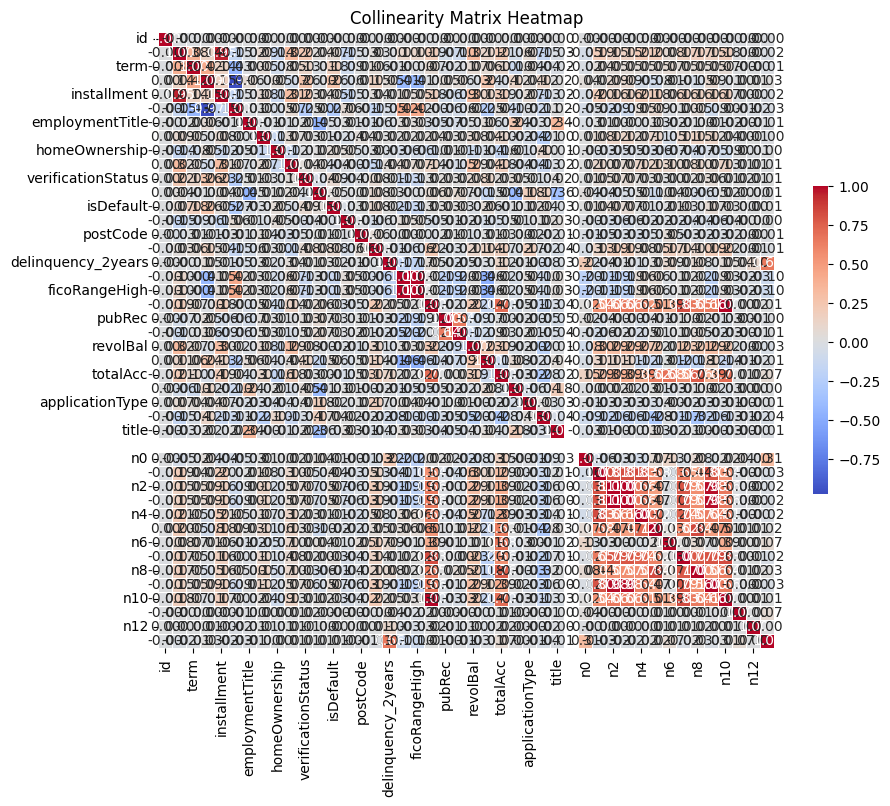

In [10]:
features = train.iloc[:,:-1]
collinearity_matrix = features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(collinearity_matrix, annot=True, fmt=".2f", cmap='coolwarm',square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Collinearity Matrix Heatmap')
plt.show()

In [11]:
train.loc[:,"n0":"n14"]=train.loc[:,"n0":"n14"].fillna(0)

In [12]:
train.corr()["employmentLength"].sort_values()

<ipython-input-12-f57638fd94ae>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()["employmentLength"].sort_values()


earliesCreditLine    -0.214540
homeOwnership        -0.128706
applicationType      -0.040109
purpose              -0.037831
n6                   -0.034145
isDefault            -0.015822
initialListStatus    -0.015678
employmentTitle      -0.013586
title                -0.004879
interestRate         -0.003302
n13                   0.000055
id                    0.000474
n11                   0.003862
subGrade              0.004276
n12                   0.007545
issueDate             0.012494
n0                    0.017362
ficoRangeLow          0.018688
ficoRangeHigh         0.018689
delinquency_2years    0.021592
dti                   0.025623
pubRecBankruptcies    0.027587
verificationStatus    0.029196
pubRec                0.031045
n14                   0.035583
revolUtil             0.035735
postCode              0.039103
openAcc               0.042909
n10                   0.051922
term                  0.054812
annualIncome          0.067188
n4                    0.076558
installm

In [13]:
train.corr(numeric_only=False)["isDefault"].sort_values()

subGrade             -0.266415
ficoRangeLow         -0.130994
ficoRangeHigh        -0.130993
annualIncome         -0.042782
employmentTitle      -0.030714
purpose              -0.029208
title                -0.025173
revolBal             -0.020929
employmentLength     -0.015822
totalAcc             -0.012756
initialListStatus    -0.007383
n5                   -0.006860
id                   -0.000351
n11                  -0.000295
regionCode            0.002822
n12                   0.003572
n8                    0.005403
postCode              0.007140
n13                   0.011021
n6                    0.012333
n0                    0.013164
applicationType       0.018197
delinquency_2years    0.020185
n4                    0.021352
pubRecBankruptcies    0.026038
pubRec                0.026558
openAcc               0.026867
n10                   0.034654
n7                    0.039918
earliesCreditLine     0.043096
n1                    0.047285
installment           0.051524
issueDat

In [14]:
#select the features with more than 0.1 corelation to predict the employmentLength
employmentLengthPre=train[["earliesCreditLine","homeOwnership","totalAcc","employmentLength","n7","n5","n2","n3","n9","n8"]]
train_employmentLengthPre=employmentLengthPre[employmentLengthPre["employmentLength"].notnull()]
test_employmentLengthPre=employmentLengthPre[employmentLengthPre["employmentLength"].isnull()]
x_train_employmentLengthPre=train_employmentLengthPre.drop(["employmentLength"],axis=1)
y_train_employmentLengthPre=train_employmentLengthPre["employmentLength"]
x_test_employmentLengthPre=test_employmentLengthPre.drop(["employmentLength"],axis=1)

#applied the random forest to predict the model
from sklearn.ensemble import RandomForestRegressor
ran1=RandomForestRegressor()
ran1.fit(x_train_employmentLengthPre,y_train_employmentLengthPre)
pre_employmentLengthPre=ran1.predict(x_test_employmentLengthPre)

train.loc[train["employmentLength"].isnull(),"employmentLength"]=pre_employmentLengthPre

In [15]:
# missing less than 1000
train[["dti","pubRecBankruptcies","revolUtil"]]=train[["dti","pubRecBankruptcies","revolUtil"]].fillna(0)

In [17]:
#normalize the feature with extreme large or small value
from sklearn.preprocessing import StandardScaler
train_preprocessing=train
train_preprocessing[["loanAmnt","installment","employmentTitle","annualIncome","postCode","dti","ficoRangeLow","ficoRangeHigh","revolBal","revolUtil","totalAcc","title"]]= StandardScaler().fit_transform(train_preprocessing[["loanAmnt","installment","employmentTitle","annualIncome","postCode","dti","ficoRangeLow","ficoRangeHigh","revolBal","revolUtil","totalAcc","title"]])
train_preprocessing = train_preprocessing.astype('float32')

In [18]:
train_preprocessing_feature=train_preprocessing.drop(["id"],axis=1)

In [19]:
train_preprocessing_feature

,loanAmnt,term,interestRate,installment,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,2.361518,5.0,19.52,1.835928,2.8,-0.672561,2.00,2.0,0.491187,2.0,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,0.411100,5.0,18.49,0.091610,3.8,1.387032,5.00,0.0,-0.437056,2.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0
2,-0.277283,5.0,16.99,-0.534604,3.7,-0.378169,8.00,0.0,-0.030950,2.0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,-0.392013,3.0,7.26,-0.370946,6.6,-0.235973,10.00,1.0,0.607217,1.0,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,-1.309857,3.0,12.99,-1.288447,4.8,-0.675057,7.44,1.0,-0.683621,2.0,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,1.214213,3.0,14.49,1.615780,4.6,-0.650617,7.00,1.0,-0.059957,0.0,...,6.0,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0
799996,0.296370,3.0,7.90,0.359490,6.6,-0.401559,10.00,0.0,0.331645,2.0,...,15.0,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0
799997,-0.965666,3.0,13.33,-0.898139,4.7,-0.651339,10.00,1.0,-0.161484,2.0,...,4.0,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0
799998,0.548777,3.0,6.92,0.589735,6.6,-0.674147,10.00,0.0,0.288134,2.0,...,10.0,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0


In [20]:
train_preprocessing_feature.corr()["isDefault"].sort_values()

subGrade             -0.266415
ficoRangeLow         -0.130994
ficoRangeHigh        -0.130993
annualIncome         -0.042782
employmentTitle      -0.030714
purpose              -0.029208
title                -0.025173
revolBal             -0.020929
employmentLength     -0.015405
totalAcc             -0.012756
initialListStatus    -0.007383
n5                   -0.006860
n11                  -0.000295
regionCode            0.002822
n12                   0.003572
n8                    0.005403
postCode              0.007140
n13                   0.011021
n6                    0.012333
n0                    0.013164
applicationType       0.018197
delinquency_2years    0.020185
n4                    0.021352
pubRecBankruptcies    0.026042
pubRec                0.026558
openAcc               0.026867
n10                   0.034654
n7                    0.039918
earliesCreditLine     0.043096
n1                    0.047285
installment           0.051524
issueDate             0.052389
homeOwne

In [21]:
train_preprocessing_feature=train_preprocessing_feature.drop(["initialListStatus","n5","n11","n12","n8","postCode","policyCode"],axis=1)

In [22]:
train_preprocessing_feature = train_preprocessing_feature.dropna(subset=['employmentTitle','title'])

In [23]:
train_preprocessing_feature=pd.get_dummies(train_preprocessing_feature)

In [24]:
x_train_full_preprocessing_feature=train_preprocessing_feature.drop(["isDefault"],axis=1)
y_train_full_preprocessing_feature=train_preprocessing_feature["isDefault"]

In [25]:
x_train_full_preprocessing_feature.isnull().sum()[x_train_full_preprocessing_feature.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression;  log=LogisticRegression();
from xgboost import XGBClassifier;  xgb=XGBClassifier(n_estimators=10);
from lightgbm import LGBMClassifier;  lgb=LGBMClassifier(n_estimators=10);
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
x_train, x_test, y_train, y_test = train_test_split(x_train_full_preprocessing_feature, y_train_full_preprocessing_feature, test_size = 0.3,random_state=42)



In [30]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
error = []
rsquared = []
# x = list(range(0.1.5,1))
for i in np.arange(0.015,0.02,0.001):
    model_xg_f = XGBClassifier(n_estimators=30,subsample=0.5,learning_rate=i)
    # Train the model on the training set
    model_xg_f.fit(x_train, y_train)
    # Make predictions on the valid set
    y_pred = model_xg_f.predict(x_test)
    resid = y_test - y_pred
    sse = np.sum(resid**2)
    Error = sse/len(y_pred)
    # calculate R^2 and adjusted R^2
    sst = np.sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (sse / sst)
    adjusted_r_squared = 1 - (sse / sst) * (len(y_test) - 1) / (len(y_test) - x_test.shape[1] - 1)
    error.append(Error)
    rsquared.append(r_squared)
    print(f'error:{Error}',i)
    print(f'r_squared:{r_squared}')

error:0.1988625 0.015
r_squared:-0.2482251418721857
error:0.1988625 0.016
r_squared:-0.2482251418721857
error:0.1988625 0.017
r_squared:-0.2482251418721857
error:0.1988625 0.018000000000000002
r_squared:-0.2482251418721857
error:0.1988625 0.019000000000000003
r_squared:-0.2482251418721857
error:0.1988625 0.020000000000000004
r_squared:-0.2482251418721857


In [31]:
for i in np.arange(30,100,10):
    model_xg_f = XGBClassifier(n_estimators=i,subsample=0.5,learning_rate=0.19)
    # Train the model on the training set
    model_xg_f.fit(x_train, y_train)
    # Make predictions on the valid set
    y_pred = model_xg_f.predict(x_test)
    resid = y_test - y_pred
    sse = np.sum(resid**2)
    Error = sse/len(y_pred)
    # calculate R^2 and adjusted R^2
    sst = np.sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (sse / sst)
    adjusted_r_squared = 1 - (sse / sst) * (len(y_test) - 1) / (len(y_test) - x_test.shape[1] - 1)
    error.append(Error)
    rsquared.append(r_squared)
    print(f'error:{Error}',i)
    print(f'r_squared:{r_squared}')

error:0.1941125 30
r_squared:-0.21841022239821317
error:0.19357916666666666 40
r_squared:-0.215062582316925
error:0.19356666666666666 50
r_squared:-0.2149841220025197
error:0.19320833333333334 60
r_squared:-0.21273492632290414
error:0.19322083333333334 70
r_squared:-0.21281338663730942
error:0.19302083333333334 80
r_squared:-0.21155802160682646
error:0.19285 90
r_squared:-0.2104857306432888


In [32]:
for i in np.arange(0.3,1,0.1):
    model_xg_f = XGBClassifier(n_estimators=70,subsample=i,learning_rate=0.19)
    # Train the model on the training set
    model_xg_f.fit(x_train, y_train)
    # Make predictions on the valid set
    y_pred = model_xg_f.predict(x_test)
    resid = y_test - y_pred
    sse = np.sum(resid**2)
    Error = sse/len(y_pred)
    # calculate R^2 and adjusted R^2
    sst = np.sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (sse / sst)
    adjusted_r_squared = 1 - (sse / sst) * (len(y_test) - 1) / (len(y_test) - x_test.shape[1] - 1)
    error.append(Error)
    rsquared.append(r_squared)
    print(f'error:{Error}',i)
    print(f'r_squared:{r_squared}')

error:0.1936125 0.3
r_squared:-0.21527180982200544
error:0.19335 0.4
r_squared:-0.2136241432194963
error:0.19322083333333334 0.5
r_squared:-0.21281338663730942
error:0.19304583333333333 0.6000000000000001
r_squared:-0.2117149422356368
error:0.19308333333333333 0.7000000000000002
r_squared:-0.21195032317885243
error:0.19289166666666666 0.8000000000000003
r_squared:-0.21074726502463936
error:0.19290416666666665 0.9000000000000001
r_squared:-0.21082572533904465


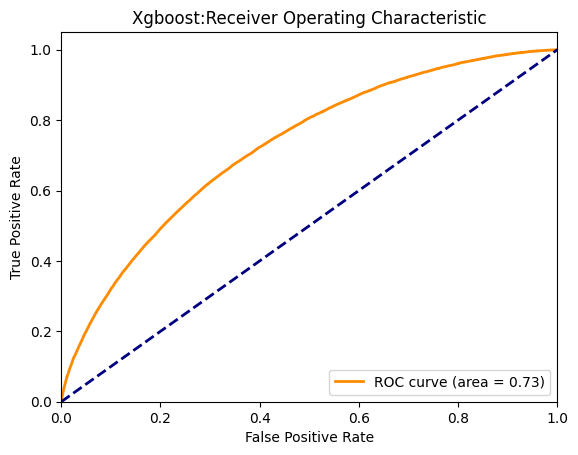

Confusion Matrix:
 [[126698   1365]
 [ 29795   2142]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.99      0.89    128063
         1.0       0.61      0.07      0.12     31937

    accuracy                           0.81    160000
   macro avg       0.71      0.53      0.51    160000
weighted avg       0.77      0.81      0.74    160000


ROC AUC Score: 0.73


In [33]:


sampled_train = x_train_full_preprocessing_feature
sampled_target = y_train_full_preprocessing_feature.loc[sampled_train.index]
X_train, X_test, y_train, y_test = train_test_split(sampled_train, sampled_target, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(x_train_full_preprocessing_feature, y_train_full_preprocessing_feature, test_size=0.2, random_state=0)

# Initialize and train the xgboost Boosting Classifier
Xg_model = XGBClassifier(n_estimators=30,subsample=0.7,learning_rate=0.13)
Xg_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = Xg_model.predict(X_test)
y_pred_proba = Xg_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Xgboost:Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print the results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nROC AUC Score: {:.2f}".format(roc_auc))